In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import mode
import itertools
import re # Regular expression
import tensorflow as tf

# Visualization files
import matplotlib.pyplot as plt
import seaborn as sns

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# models and tuning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Pre-processing

In [ ]:
# Import files from directories
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Natural Language Processing/Project/BBC News Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Natural Language Processing/Project/BBC News Test.csv')

### Exploratory Data Analysis

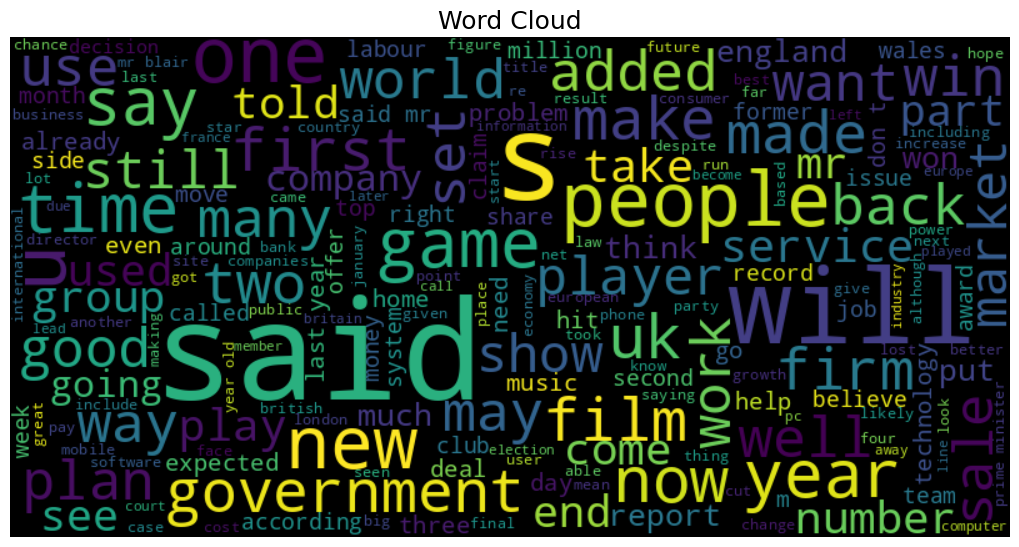

In [ ]:
from wordcloud import WordCloud

# Concatenate all text data for generating the word cloud
all_text = ' '.join(train['Text'])

# Word Cloud using the News Titles in order to see the most common key words
plt.figure(figsize = (10, 7))
wordcloud = WordCloud(width = 800, height = 400, random_state=21, max_font_size=110).generate(all_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud', size=18);

In [ ]:
print("train: \n")
print(train.info())
print("test: \n")
print(test.info())

train: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
test: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ArticleId  735 non-null    int64  
 1   Text       735 non-null    object 
 2   Category   0 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 17.4+ KB
None


## Data visualization

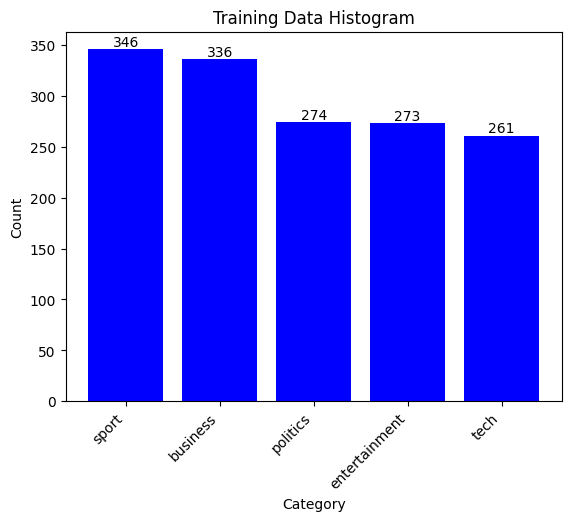

In [ ]:
category_counts = train['Category'].value_counts()
plt.bar(category_counts.index, category_counts, color='blue')
plt.title('Training Data Histogram')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Count')
for i, count in enumerate(category_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

In [ ]:
# Take a look waht texts for each 'Category' looks like
print('sports text example:\n ',train[train['Category']== 'sport']['Text'].iloc[0],'\n')
print('business text example:\n ',train[train['Category']== 'business']['Text'].iloc[0],'\n')
print('politics text example:\n ',train[train['Category']== 'politics']['Text'].iloc[0],'\n')
print('entertainment text example:\n ',train[train['Category']== 'entertainment']['Text'].iloc[0],'\n')
print('tech text example:\n ',train[train['Category']== 'tech']['Text'].iloc[0],'\n')



sports text example:
  wales silent on grand slam talk rhys williams says wales are still not thinking of winning the grand slam despite a third six nations win.   that s the last thing on our minds at the moment   said williams  a second- half replacement in saturday s 24-18 win over france in paris.  we all realise how difficult a task it is to go up to scotland and beat them.  we ve come unstuck there a couple of times recently so our focus is on that game and we ll worry about ireland hopefully after we ve beaten scotland.  with captain gareth thomas ruled out of the rest of the campaign with a broken thumb  williams is vying for his first start in the championship so far.  kevin morgan is probably favourite to replace thomas at full-back  leaving williams and hal luscombe to battle for the right wing berth. a hamstring injury denied luscombe the opportunity to make a third successive start  but the dragons winger is expected to be fit for the trip to murrayfield on 13 march. hooke

In [ ]:
# Check dataframe for missing values
train.isnull().sum()
test.isnull().sum()

ArticleId      0
Text           0
Category     735
dtype: int64

## Dataset cleaning

In [ ]:
# Count the duplicated values in the 'Text' column
duplicated_text_count = train.duplicated(subset=['Text']).sum()

# Count the duplicated values based on both 'Text' and 'Category'. If the counts are the same as above,those duplicates have consistent 'Category'
duplicated_textcat_count = train.duplicated(subset=['Text', 'Category']).sum()

# Print the counts
print(f'There are {duplicated_text_count} rows with the same texts in the training data.')
print(f'There are {duplicated_textcat_count} rows with the same texts and categories in the training data.')

# I am curious to see how those duplicates look like. Let's just look at a few.
duplicates = train[train.duplicated(subset=['Text'], keep=False)].sort_values(by='Text')
print( duplicates.head(6) )



There are 50 rows with the same texts in the training data.
There are 50 rows with the same texts and categories in the training data.
      ArticleId                                               Text  \
494        1326  ask jeeves joins web log market ask jeeves has...   
228        1098  ask jeeves joins web log market ask jeeves has...   
1430       1042  aviator  creator  in oscars snub the man who s...   
695         374  aviator  creator  in oscars snub the man who s...   
443        1847  blind student  hears in colour  a blind studen...   
1317        145  blind student  hears in colour  a blind studen...   

           Category  
494            tech  
228            tech  
1430  entertainment  
695   entertainment  
443            tech  
1317           tech  


Samples in training data after moving duplicates: 1440


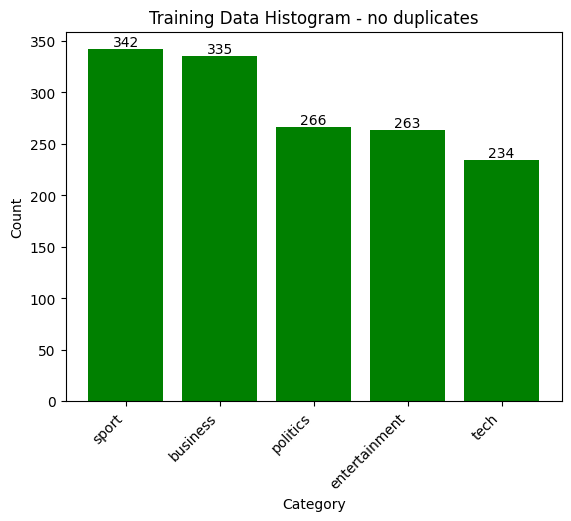

In [ ]:
# Remove duplicates
train = train.drop_duplicates(subset=['Text'])

# Check train data counts. Originally training data has 1490 rows and 50 rows should be dropped. So, I expect 1440 rows left.
print(f'Samples in training data after moving duplicates: {train.shape[0]}')

# Let's look at the histogram for 'Category' again
category_counts = train['Category'].value_counts()
plt.bar(category_counts.index, category_counts, color='green')
plt.title('Training Data Histogram - no duplicates')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Count')
for i, count in enumerate(category_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

### TF-IDF

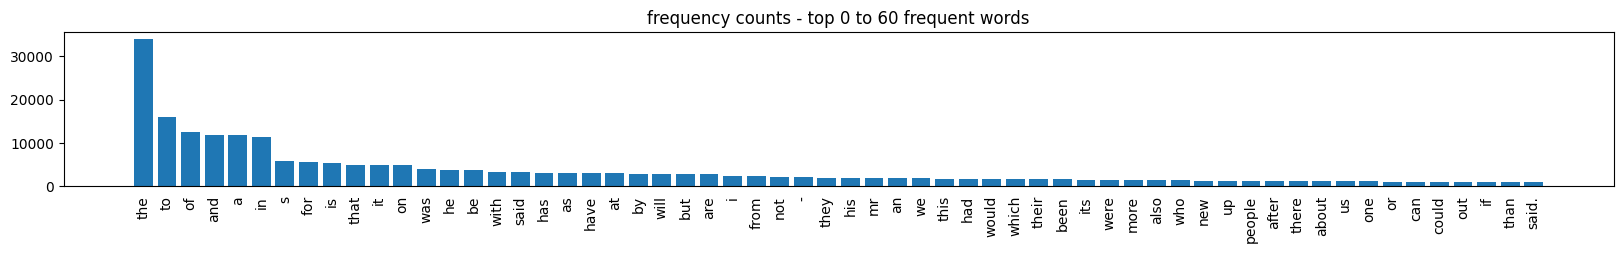

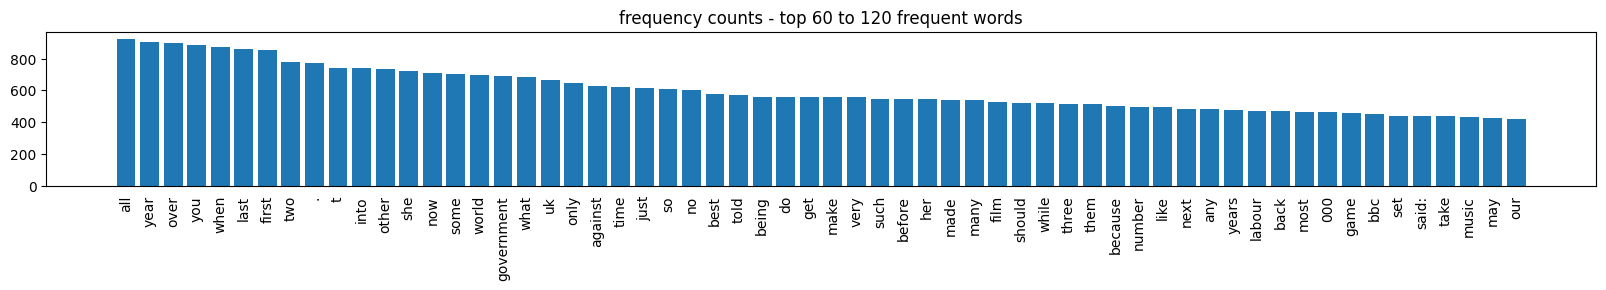

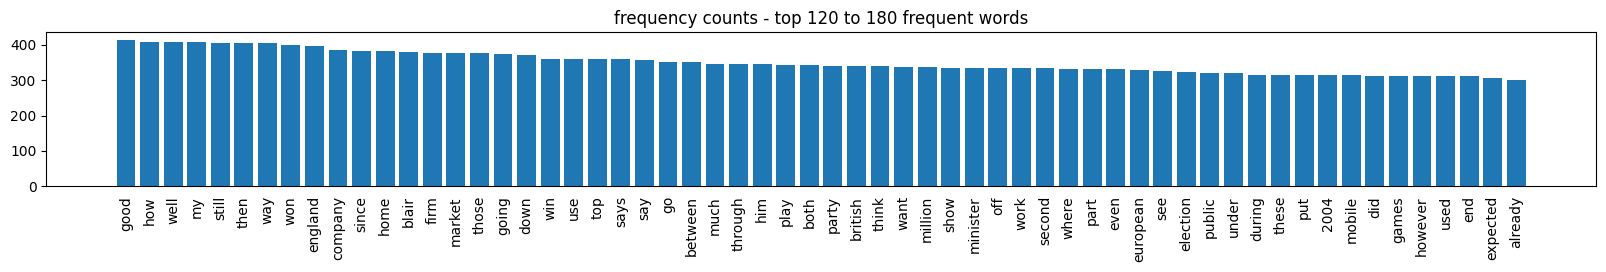

In [ ]:
# plot some most frequent words
def frequency_plot(frequency,start,end):
    frequency = frequency[start:end]
    plt.figure(figsize=(20,2))
    plt.bar(frequency.index, frequency)
    plt.title(f'frequency counts - top {start} to {end} frequent words')
    plt.xticks(ticks=frequency.index,rotation=90, labels=frequency.index)
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.show()

frequency = train['Text'].str.split().explode().value_counts()

frequency_plot(frequency,0,60)
frequency_plot(frequency, 60,120)
frequency_plot(frequency, 120,180)

In [ ]:
def text_preprocessing(df):
    """
    This function does in place replacement of data so it won't return anything
    """
    # convert to lower cases
    df['Text']=df['Text'].str.lower()

    # remove punctuation
    df['Text'] = df['Text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc))

    # remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    df['Text'] = df['Text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))

    # remove extra spaces
    df['Text'] = df['Text'].apply(lambda doc: re.sub(' +', ' ', doc))

    # stemming
    porter_stemmer = PorterStemmer()
    df['Text'] = df['Text'].apply(lambda doc:  [porter_stemmer.stem(word) for word in word_tokenize(doc) ])
    df['Text'] = df['Text'].apply(lambda words: ' '.join(words))

# take a look at text 0
train_copy = train.copy()
print('1st text before preprocessing: \n',train_copy['Text'][0])
text_preprocessing(train_copy)
print('\n1st text after preprocessing: \n',train_copy['Text'][0])

1st text before preprocessing: 
 worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and pr

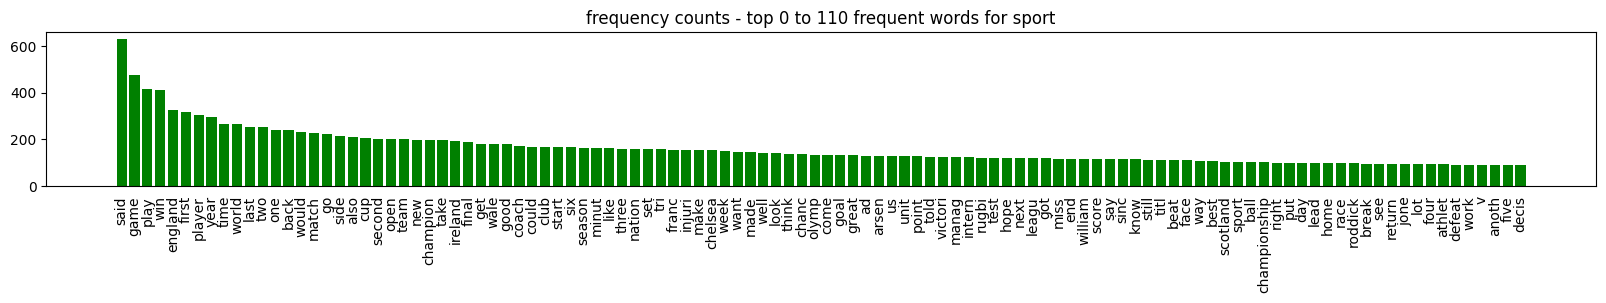

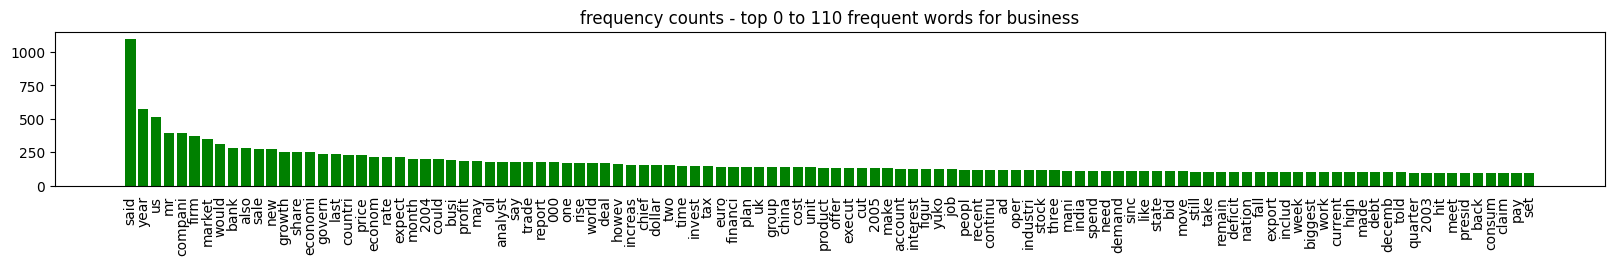

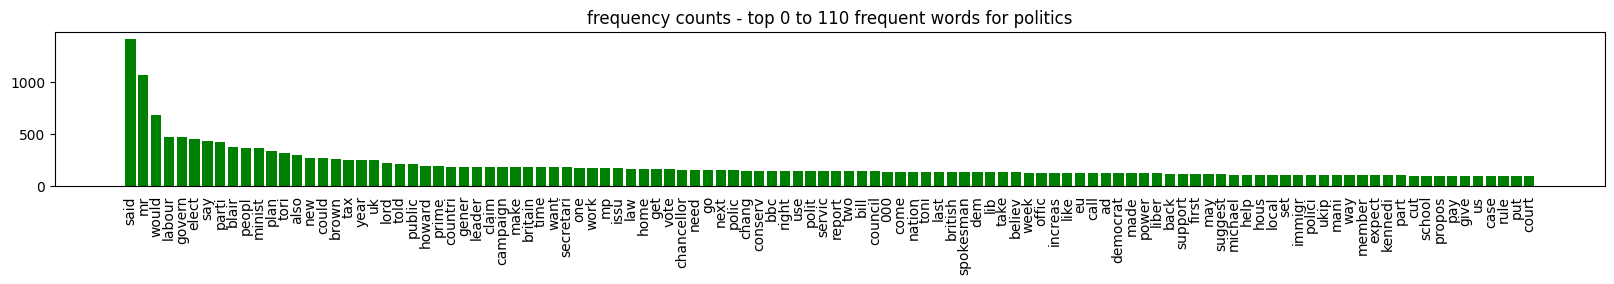

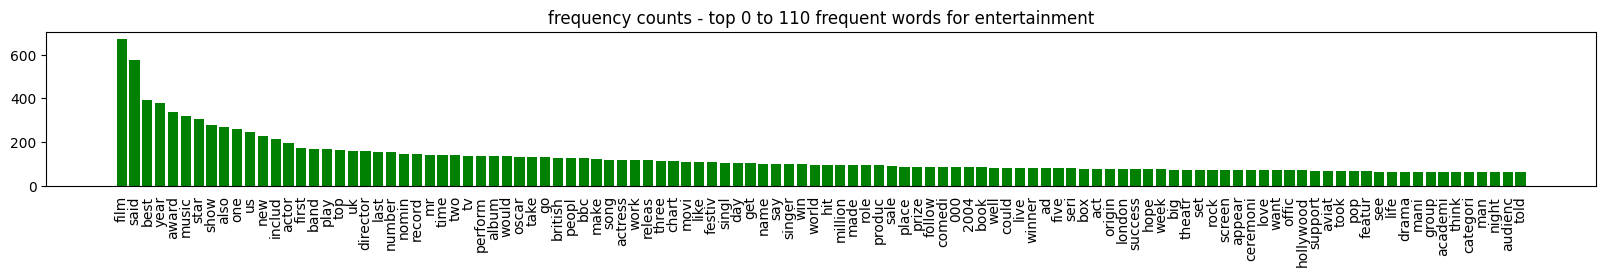

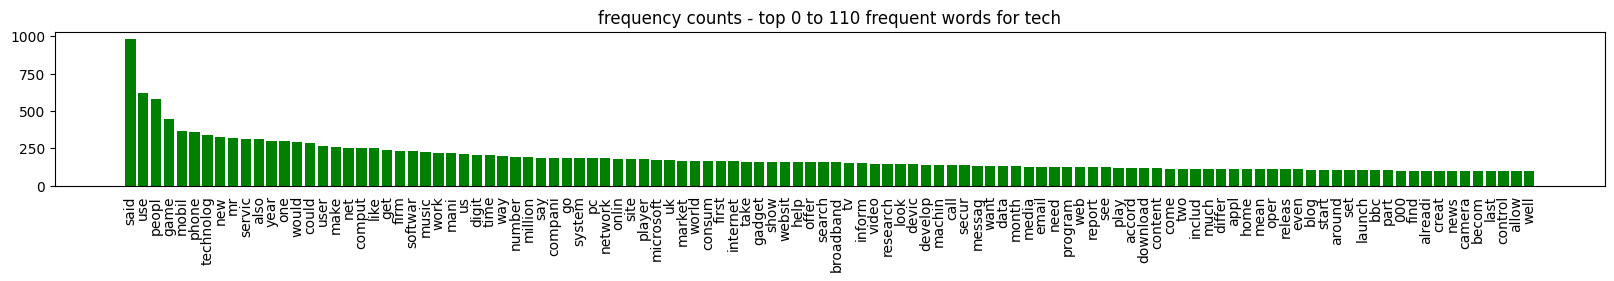

In [ ]:
# plot top 110 frequent words in each category after some word preprocessing
def frequency_plot(df ,start,end, Category):
    df_topic=df[df['Category']== Category]
    frequency = df_topic['Text'].str.split().explode().value_counts()

    frequency = frequency[start:end]
    plt.figure(figsize=(20,2))
    plt.bar(frequency.index, frequency, color = 'green')
    plt.title(f'frequency counts - top {start} to {end} frequent words for {Category}')
    plt.xticks(ticks=frequency.index,rotation=90, labels=frequency.index)
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.show()

frequency_plot(train_copy,0,110,'sport')
frequency_plot(train_copy,0,110,'business')
frequency_plot(train_copy,0,110,'politics')
frequency_plot(train_copy,0,110,'entertainment')
frequency_plot(train_copy,0,110,'tech')

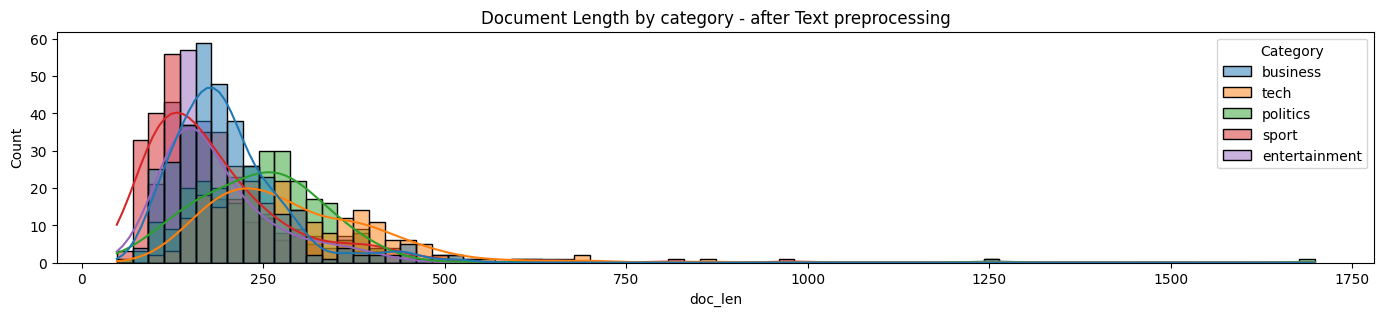

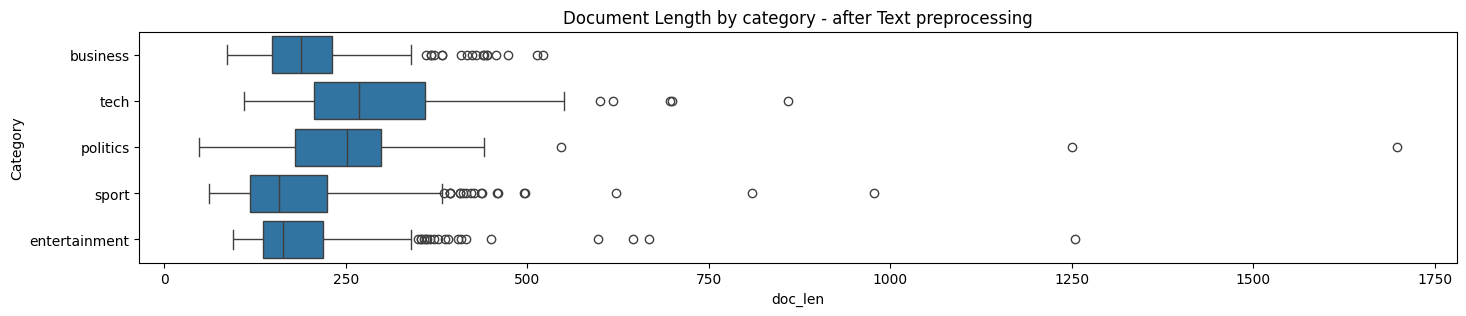

In [ ]:
# Take a look at document lengths

# Get document lengths
train_copy['doc_len'] = train_copy['Text'].apply(lambda words: len(words.split()))

# Historgram by category
fig, ax = plt.subplots(figsize=(17, 3))
sns.histplot(
    data = train_copy,
    x = 'doc_len',
    kde=True,
    hue = 'Category'
    ).set(
        title = 'Document Length by category - after Text preprocessing');

# boxplot by category
fig, ax = plt.subplots(figsize=(17, 3))
sns.boxplot(
    data = train_copy,
    x = 'doc_len',
    y = 'Category',

    ).set(
        title = 'Document Length by category - after Text preprocessing');



# Unsupervised Model Training
NMF

In [ ]:
# Label Permutation
def predict(df,yp, n=5,label_portion=1): #should probably call this function label_permutation but let's leave it as it is for now
    """
    input
    df: DataFrame
    yp: dimension (1440 *5). training size (no dup) * class. It's in indices order already from call in NMF output!! numpy format,
    n: number of labels. (would always to 5 for this project). integer

    return
    best_ypred: list of predication using permutation that produce best accuracy, note it's in indices order!! list format
    best_label_mapping_yp: dictionary that map unsupervise learning labels to ground truth labels, dictionary format
    best_accuracy: accuracy from permutation that produce best accuracy, list format, float format
    """
    # labeled sample size
    #yt
    yt=df['Category']

    if label_portion != 1:
        np.random.seed(1)
        sample_size = int(label_portion * df.shape[0])
        rows = np.random.choice(np.arange(df.shape[0]), sample_size  )
        yt=yt.iloc[rows]

    # yp transfer
    yp = np.argmax(yp, axis=1) # Now yp is np array also

    if label_portion !=1:
        yp= yp[rows]

    # intialize several parameters
    best_accuracy=float('-inf')
    best_permutation=()
    best_label_mapping_yp = {}
    best_ypred=[]
    permutations=list(itertools.permutations(np.arange(n))) # a list of size n tuples

    # get actual 'Category' ['business', 'tech', 'politics', 'sport', 'entertainment']
    unique_labels= yt.unique()

    # map 'numerical labels' to 'Category': Ex:  {0: 'business', '1: 'tech', 2: 'politics', 3: 'sport', : 'entertainment'}
    label_mapping_yt = {i: label  for i,label in enumerate(unique_labels)}

    for permutation in permutations:
        label_mapping_yp = {perm:  label_mapping_yt[i]  for  i,perm in enumerate(list(permutation))}
        yp_gt = [label_mapping_yp[y] for y in yp] # transfer to ground truth label
        accuracy = (yt==yp_gt).sum()/len(yt)
        # update to keep the best accuracy permutation
        if accuracy> best_accuracy:
            best_permutation = permutation
            best_accuracy=accuracy
            best_ypred = yp_gt
            best_label_mapping_yp = label_mapping_yp

    return (best_ypred ,best_label_mapping_yp, best_accuracy)

In [ ]:
# Function for NMF training
def MF_training(df, min_df=0.0, max_df = 1.0, norm='l1', stop_words = None, ngram_range= (1,1), l1_ratio =0.0, label_portion =1 ):
        """
        This function is for NMF training. It has text preprocessing, tfidf, and NMF.

        Input:
        df: df is training data. df has default size to be the same size of training data (minus duplicates). Data frame format.
        label_portion: portions of labels for label permutation. Can set to be less than 1 for NMF but has to be 1 for supervised model. float format

        return:
        y_pred_train_labeled_data: list of predications only on labeled data! list format
        label_mapping_yp: dictionary that map unsupervise learning labels to ground truth labels, dictionary format
        tfidf, nmf: trained models
        accuracy: accuracy only on labeled data (so for NMF, if we include 1% of labels. the accuracy is only those small part of labeled data)!! float format

        """
        # Text preprocess
        text_preprocessing(df)

        # TFIDF model
        tfidf = TfidfVectorizer(
                                 min_df = min_df,
                                 max_df = max_df,
                                 norm = norm,
                                 stop_words =stop_words,
                                 ngram_range = ngram_range)
        tfidf_train = tfidf.fit_transform(df['Text'])

        # NMF model
        nmf = NMF(n_components=5,
                        init='nndsvda',
                        solver = 'mu',
                        beta_loss = 'kullback-leibler',
                        l1_ratio = l1_ratio,
                        random_state = 1)
        nmf_train = nmf.fit_transform(tfidf_train) #nmf_train is a np array of dimension (1440*5)

        # Transform unsupervised learning labels to ground truth labels
        y_pred_train_labeled_data , label_mapping_yp , labeled_data_accuracy = predict(df=df, yp=nmf_train, label_portion=label_portion)

        print(f'training accuracy on labeled portion ({label_portion}) of data is:', labeled_data_accuracy)

        return labeled_data_accuracy, tfidf, nmf, label_mapping_yp, y_pred_train_labeled_data # accuracy, y_pred_train is only on labeled data!!!


In [ ]:
# function to predict testing data
def predict_data(df,tfidf, nmf, label_mapping_yp ):
    # predict testing data
    text_preprocessing(df)
    tfidf = tfidf.transform(df['Text'])
    nmf = nmf.transform(tfidf)
    y_pred = np.argmax(nmf, axis=1)
    y_pred = [label_mapping_yp[y] for y in y_pred]
    return y_pred

# function to submit results
def submit_result(y_pred_test):
    test_pred = pd.DataFrame(columns=['ArticleId', 'Category'])
    test_pred['ArticleId'] = test['ArticleId']
    test_pred['Category'] = y_pred_test

    #save and submit test dataframe
    try:
        test_pred.to_csv('submission.csv', index=False)
    except:
        pass

In [ ]:
# Training with the model (first try with no tuning)
train_copy = train.copy()
train_accuracy, tfidf, nmf, label_mapping_yp, ypred_train_no_tune = MF_training(train_copy, label_portion =1)

training accuracy on labeled portion (1) of data is: 0.9291666666666667


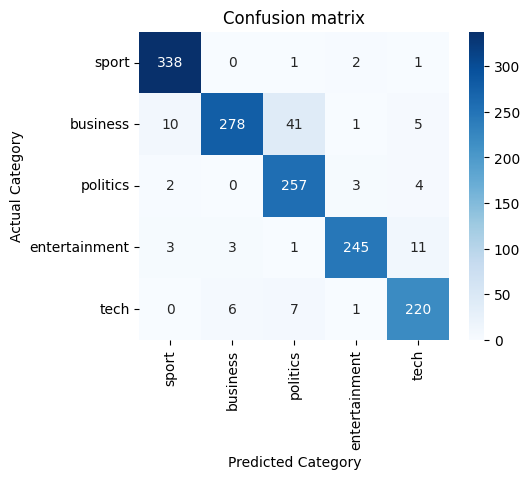

In [ ]:
# Since the data isn't perfectly balanced. Let't take a look at the confusion matric.

# Confusion matrix function
def plot_conf_matrix(yt, yp, label_order= ['sport','business','politics','entertainment','tech'] ):
        cfm = confusion_matrix(yt,yp,labels =label_order)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cfm, annot=True, fmt='.0f',cmap='Blues',xticklabels=label_order, yticklabels=label_order)
        plt.xlabel('Predicted Category')
        plt.ylabel('Actual Category')
        plt.title('Confusion matrix')
        plt.show()

# Plot
plot_conf_matrix(train['Category'],ypred_train_no_tune )

In [ ]:
# Train testing data and submit the results
test_copy = test.copy()
y_pred_test =  predict_data(test_copy, tfidf, nmf, label_mapping_yp)
submit_result(y_pred_test)

## Model Tuning

In [ ]:
# Model tuning
def model_tuning(data, test_size= 0.2):
    """
    data: data frame format
    test_size: size of validation set, float format:
    """

    # initilize besties
    best_accuracy=float('-inf')
    best_pred_train = []
    best_pred_test =[]
    best_mindf = None
    best_maxdf = None
    best_sw=[]
    best_norm = None
    best_ngram_range = ()
    bestl1_ratio = None
    best_tfidf = None
    best_NMF = None

    # training and testing accuracies
    training_acc =[]
    testing_acc = []

    # Split data
    X, y = data.drop(['Category'], axis=1), data['Category']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state=10)
    X_train_df = pd.DataFrame(X_train, columns=X.columns)
    y_train_df = pd.DataFrame(y_train, columns=['Category'])
    X_train_df = pd.concat([X_train_df, y_train_df], axis=1)

    # Preprocessing
    text_preprocessing(X_train)
    text_preprocessing(X_test)

    # Try different parameters
    for min_df in [2,10]:
        for max_df in [0.8, 0.9, 0.95]:
            for norm in ['l1','l2']:
                for stop_words in [["said","would", "also"],None]:
                    for ngram_range in [(1,1),(1,2)]:
                        for l1_ratio in [0.4, 0.5]:
                                    tfidf = TfidfVectorizer(min_df = min_df,
                                                           max_df = max_df,
                                                           norm = norm,
                                                           stop_words =stop_words,
                                                           ngram_range = ngram_range)
                                    tfidf_train = tfidf.fit_transform(X_train['Text'])
                                    nmf = NMF(n_components=5,
                                            init='nndsvda',
                                             solver = 'mu',
                                              beta_loss = 'kullback-leibler',
                                              l1_ratio = l1_ratio,
                                              random_state = 1)
                                    nmf_train = nmf.fit_transform(tfidf_train)

                                    # Transform unsupervised learning labels to ground truth labels and get accuracy
                                    y_pred_train , label_mapping_yp , accuracy = predict(X_train_df, nmf_train)
                                    training_acc.append(accuracy)

                                    # predict testing data
                                    tfidf_test = tfidf.transform(X_test['Text'])
                                    nmf_test = nmf.transform(tfidf_test)
                                    y_pred_test = np.argmax(nmf_test, axis=1)
                                    y_pred_test = [label_mapping_yp[y] for y in y_pred_test]
                                    test_accuracy = accuracy_score(y_test, y_pred_test)
                                    testing_acc.append(test_accuracy)
                                    print(f'min_df: {min_df}, max_df: {max_df}, tfidf norm: {norm}, stop_words: {stop_words}, ngram_range: {ngram_range}, l1_ratio: {l1_ratio},train_accuracy:  {accuracy}, test_accuracy: {test_accuracy}')

                                    # update besties
                                    if test_accuracy > best_accuracy:
                                                    best_accuracy=test_accuracy
                                                    best_pred_train = y_pred_train
                                                    best_pred_test = y_pred_test
                                                    best_mindf = min_df
                                                    best_maxdf = max_df
                                                    best_sw=stop_words
                                                    best_norm = norm
                                                    best_ngram_range = ngram_range
                                                    bestl1_ratio  = l1_ratio

    print(f'best_accuracy: {best_accuracy},best_max_df: {best_mindf}, best_maxdf: {best_maxdf}, best_sw: {best_sw}, best_norm: {best_norm}, best_ngram_range: {best_ngram_range}, bestl1_ratio: {bestl1_ratio}')

    return (best_tfidf,best_NMF, best_pred_train, best_pred_test, training_acc, testing_acc )

In [ ]:
train_copy = train.copy()
tfidf_2, nmf_2, best_pred_train, best_pred_test, training_acc, testing_acc = model_tuning(train_copy, test_size=0.2)

min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: ['said', 'would', 'also'], ngram_range: (1, 1), l1_ratio: 0.4,train_accuracy:  0.9505208333333334, test_accuracy: 0.9305555555555556
min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: ['said', 'would', 'also'], ngram_range: (1, 1), l1_ratio: 0.5,train_accuracy:  0.9505208333333334, test_accuracy: 0.9305555555555556
min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: ['said', 'would', 'also'], ngram_range: (1, 2), l1_ratio: 0.4,train_accuracy:  0.9661458333333334, test_accuracy: 0.9548611111111112
min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: ['said', 'would', 'also'], ngram_range: (1, 2), l1_ratio: 0.5,train_accuracy:  0.9661458333333334, test_accuracy: 0.9548611111111112
min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: None, ngram_range: (1, 1), l1_ratio: 0.4,train_accuracy:  0.9496527777777778, test_accuracy: 0.9305555555555556
min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: None, ngram_range: (1, 1), l1_ratio: 0.5,tra

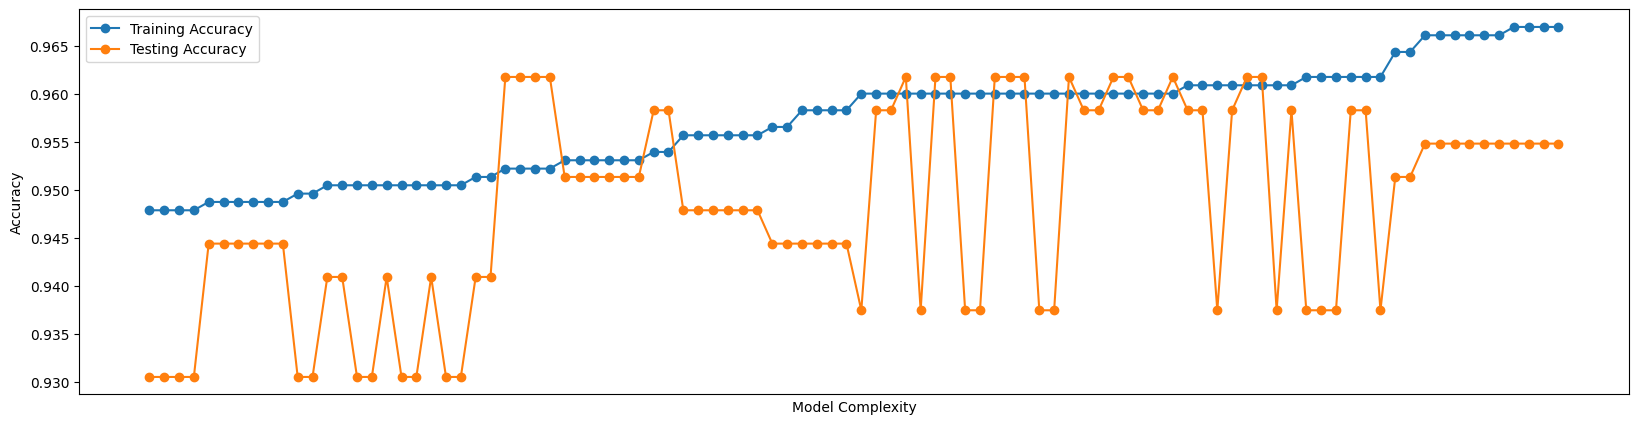

In [ ]:
# Sort data
sorted_indices = np.argsort(training_acc)
training_acc = np.array(training_acc)[sorted_indices]
testing_acc = np.array(testing_acc)[sorted_indices]

# Graph
runs = list(range(1, len(training_acc) + 1))
plt.figure(figsize=(20,5))
plt.plot(runs, training_acc, label='Training Accuracy', marker='o')
plt.plot(runs, testing_acc, label='Testing Accuracy', marker='o')
plt.xlabel('Model Complexity')
plt.ylabel('Accuracy')

plt.legend()
plt.xticks([])
plt.show()

## Results

In [ ]:
# Let's re-train all training data again use the best parameters
train_copy = train.copy()
train_accuracy, tfidf, nmf, label_mapping_yp, ypred_train  = MF_training(train_copy, min_df=2, max_df=0.95,  norm='l2', ngram_range= (1,2), l1_ratio =0.5)

training accuracy on labeled portion (1) of data is: 0.95


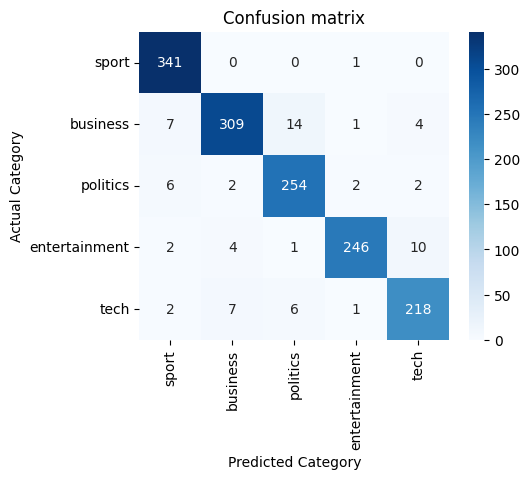

In [ ]:
# Plot confusion matrix on prediction on training data
plot_conf_matrix(train['Category'],ypred_train )

In [ ]:
# Use chi-squresd squred test to see the most correlated term in each category
feature_vecs = tfidf.fit_transform(train_copy['Text']).toarray()
print(feature_vecs.shape)
print(len(feature_vecs))
print(label_mapping_yp)

N = 2
for label_id, category in label_mapping_yp.items():
    chi2_corr = chi2(feature_vecs,  train_copy['Category'] == category)
    indices = np.argsort(chi2_corr[0])
    fv_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in fv_names if len(v.split(' ')) == 1]
    bigrams = [v for v in fv_names if len(v.split(' ')) == 2]

    print(f"** {category}:")
    print("  . Top 2 correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Top 2 correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

(1440, 44899)
1440
{2: 'business', 4: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}
** business:
  . Top 2 correlated unigrams:
       . growth
       . bank
  . Top 2 correlated bigrams:
       . econom growth
       . interest rate
** tech:
  . Top 2 correlated unigrams:
       . phone
       . mobil
  . Top 2 correlated bigrams:
       . search engin
       . mobil phone
** politics:
  . Top 2 correlated unigrams:
       . elect
       . labour
  . Top 2 correlated bigrams:
       . mr brown
       . mr blair
** sport:
  . Top 2 correlated unigrams:
       . champion
       . cup
  . Top 2 correlated bigrams:
       . champion leagu
       . six nation
** entertainment:
  . Top 2 correlated unigrams:
       . award
       . film
  . Top 2 correlated bigrams:
       . name best
       . box offic


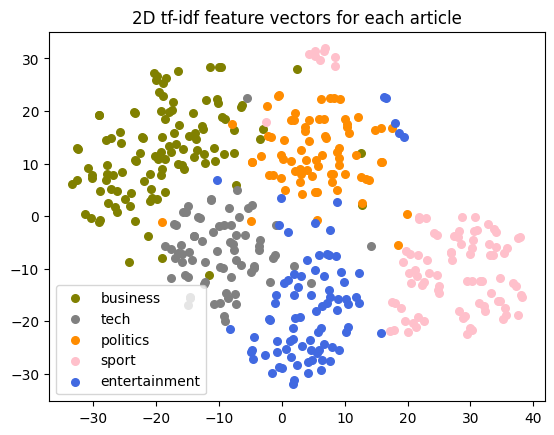

In [ ]:
# t-SNE for feature vector visualization

# Choose subset of features (because t-SNE is computationaly expensive)
sample_size = int(len(feature_vecs) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(feature_vecs)), size=sample_size, replace=False)

# t-SNE
lowd_features = TSNE(n_components=2, random_state=1).fit_transform(feature_vecs[indices])
colors = [ 'pink', 'darkorange','olive', 'royalblue', 'gray',]
for label_id, category in label_mapping_yp.items():
    points = lowd_features[(train_copy['Category'].iloc[indices]== category).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[label_id], label=category)
plt.title("2D tf-idf feature vectors for each article")
plt.legend()

# Supervised Model Training

In [ ]:
# prepare training and testing data
train_copy=train.copy()
text_preprocessing(train_copy)
test_copy=test.copy()
text_preprocessing(test_copy)

# TFIDF model
tfidf = TfidfVectorizer(min_df = 2,
                        max_df = 0.95,
                        norm = 'l2',
                        stop_words =None,
                        ngram_range = (1,2))
tfidf_train = tfidf.fit_transform(train_copy['Text'])
tfidf_test = tfidf.transform(test_copy['Text'])

In [ ]:
# random forest
rf= RandomForestClassifier()

# grid search for rf
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [20, 50],
    'min_samples_split': [10,20],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(tfidf_train, train_copy['Category'])

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_rf_model = grid_search.best_estimator_
print(grid_search.best_score_)
print(best_params)

0.9479166666666666
{'max_depth': 50, 'min_samples_split': 20, 'n_estimators': 50}


In [ ]:
# Peek at some grid search results
#pd.DataFrame(grid_search.cv_results_)

0.9993055555555556


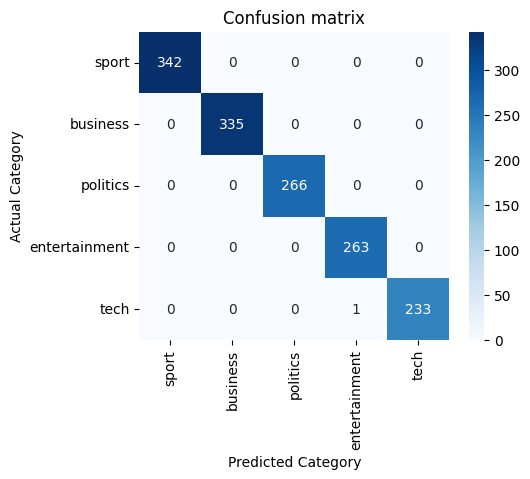

In [ ]:
# retrain with all trainind data
training_accuracies=[]

# Fit and predict all training data with best rf model
best_rf_model.fit(tfidf_train,train_copy['Category'])
y_pred_train = best_rf_model.predict(tfidf_train)
accuracy_score_train = accuracy_score( train['Category'], y_pred_train   )
print(accuracy_score_train)
training_accuracies.append(accuracy_score_train)
plot_conf_matrix(train['Category'], y_pred_train )

# predict testing data
# y_pred_test = best_rf_model.predict(tfidf_test)
# submit_result(y_pred_test)

# Comparision

### Random Forest

rf training accuracy score on 70% data:  0.9680555555555556


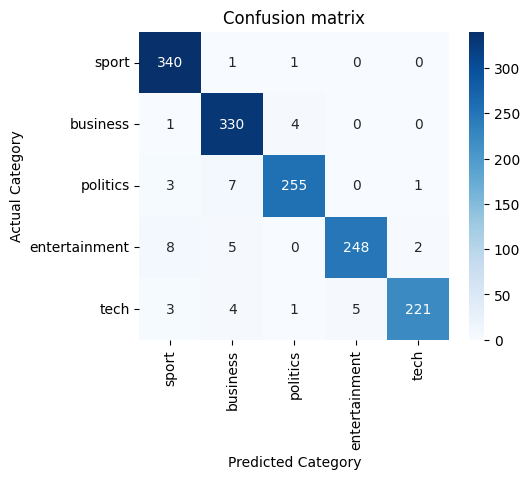

In [ ]:
# retrain rf with 70% training data

# choose portionof sample data
portion = 0.7
sample_size = int(train_copy.shape[0] * portion)
indices = np.random.choice(np.arange(train_copy.shape[0]),sample_size )

# retrain best rf model with sample data
best_rf_model.fit(tfidf_train[indices],train_copy['Category'].iloc[indices])
y_pred_train = best_rf_model.predict(tfidf_train)
accuracy_score_train = accuracy_score( train['Category'], y_pred_train   )
print('rf training accuracy score on 70% data: ', accuracy_score_train)
training_accuracies.append(accuracy_score_train)
plot_conf_matrix(train['Category'] , y_pred_train )

# # predict testing data
# y_pred_test_70 = best_rf_model.predict(tfidf_test)

rf training accuracy score on 50% data:  0.9402777777777778


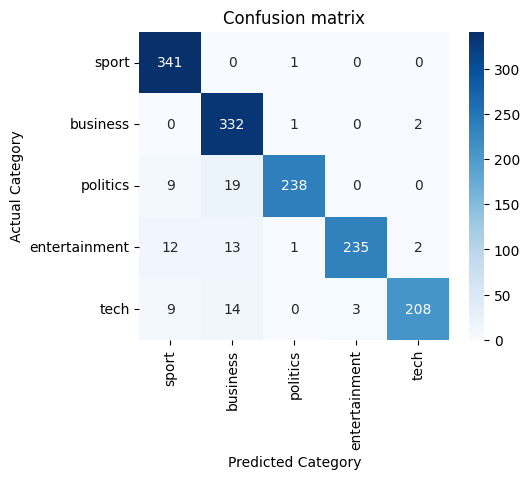

In [ ]:
# retrain rf with 50% training data

# choose portionof sample data
portion = 0.5
sample_size = int(train_copy.shape[0] * portion)
indices = np.random.choice(np.arange(train_copy.shape[0]),sample_size )
# print(indices)
# print(tfidf_train[indices,:])

# retrain best rf model with sample data
best_rf_model.fit(tfidf_train[indices],train_copy['Category'].iloc[indices])
y_pred_train = best_rf_model.predict(tfidf_train)
accuracy_score_train = accuracy_score( train['Category'], y_pred_train   )
print('rf training accuracy score on 50% data: ',accuracy_score_train)
training_accuracies.append(accuracy_score_train)
plot_conf_matrix(train['Category'] , y_pred_train )

# # predict testing data
# y_pred_test_50 = best_rf_model.predict(tfidf_test)

rf training accuracy score on 20% data:  0.9041666666666667


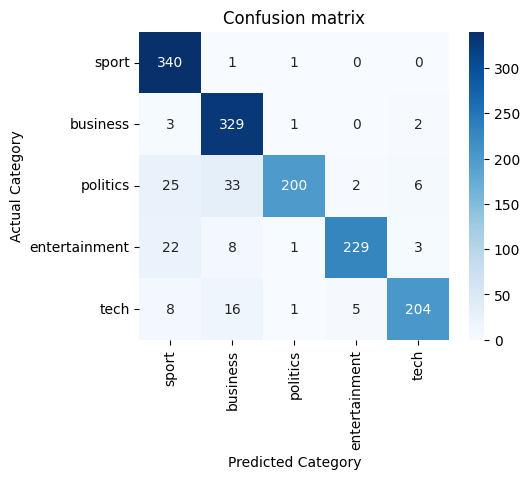

In [ ]:
# retrain rf with 20% trainind data (comment out just to save running time.)

# choose portionof sample data
portion = 0.2
sample_size = int(train_copy.shape[0] * portion)
indices = np.random.choice(np.arange(train_copy.shape[0]),sample_size )

# retrain best rf model with sample data
best_rf_model.fit(tfidf_train[indices],train_copy['Category'].iloc[indices])
y_pred_train = best_rf_model.predict(tfidf_train)
accuracy_score_train = accuracy_score( train['Category'], y_pred_train   )
print('rf training accuracy score on 20% data: ', accuracy_score_train)
training_accuracies.append(accuracy_score_train)
plot_conf_matrix(train['Category'] , y_pred_train )

# # predict testing data
# y_pred_test_20 = best_rf_model.predict(tfidf_test)

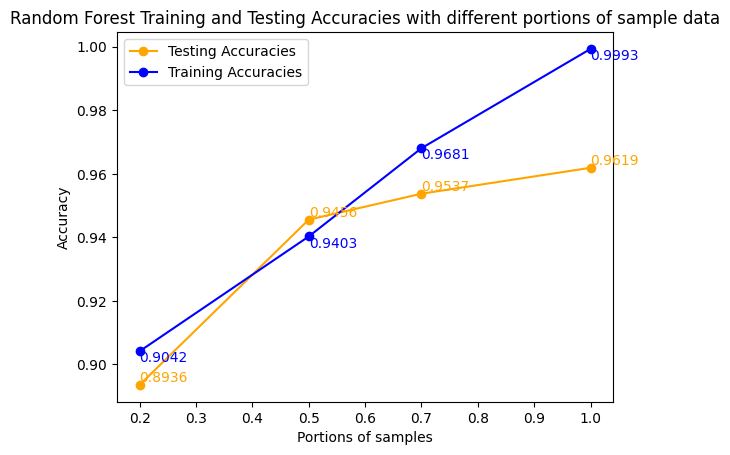

In [ ]:
testing_accuracies = [0.9619, 0.95374, 0.94557, 0.89357]
x_values = [1, 0.7, 0.5, 0.2]

# Plot lines
plt.plot(x_values, testing_accuracies, label='Testing Accuracies', marker='o', color='orange')
plt.plot(x_values, training_accuracies, label='Training Accuracies', marker='o', color='blue')

for i, txt in enumerate(testing_accuracies):
    plt.text(x_values[i], testing_accuracies[i], f'{txt:.4f}', ha='left', va='bottom', color='orange')

for i, txt in enumerate(training_accuracies):
    plt.text(x_values[i], training_accuracies[i], f'{txt:.4f}', ha='left', va='top', color='blue')

plt.xlabel('Portions of samples')
plt.ylabel('Accuracy')
plt.title('Random Forest Training and Testing Accuracies with different portions of sample data')
plt.legend()
plt.show()

### NMF

training accuracy on labeled portion (0.1) of data is: 0.9513888888888888


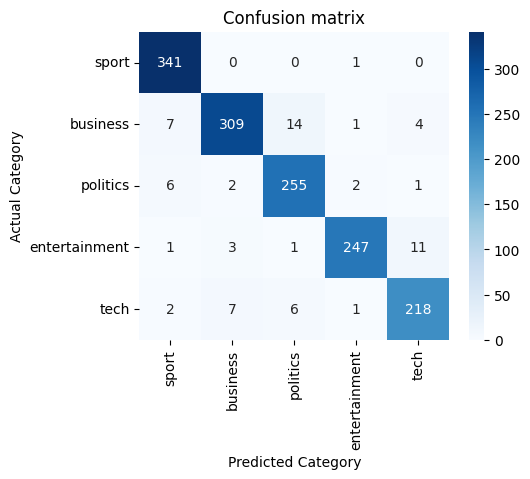

training data accuracy of 10% labeled data (and 100% unlabeled data):  0.9513888888888888


In [ ]:
# How 10% labeled data (100% trainign data) perform on NMF
training_accuracies_nmf = []
train_copy = train.copy()
_, tfidf, nmf, label_mapping_yp,_ = MF_training(train_copy, min_df=2, max_df=0.95,  norm='l2', ngram_range= (1,2), l1_ratio =0.5,label_portion=0.10)
y_pred_train = predict_data(train_copy,tfidf, nmf, label_mapping_yp )

plot_conf_matrix(train['Category'],y_pred_train )
train_acc = accuracy_score(train['Category'],y_pred_train)
training_accuracies_nmf.append(train_acc)
print('training data accuracy of 10% labeled data (and 100% unlabeled data): ', train_acc)

#  Let's predict the testing data and submit results after tuning and see how it goes
test_copy = test.copy()
y_pred_test_nmf10 = predict_data(test_copy,tfidf, nmf, label_mapping_yp )

# Conclusion
In conclusion, NMF outperforms random forest in test accuracy, avoid overfitting, and efficient use of labeled data